In [1]:
import os
import numpy as np
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Define constants
DATA_DIR = '/content/drive/MyDrive/expressions'
IMG_SIZE = (108,108)
NUM_CLASSES = 7

In [3]:
# Load images and labels
images = []
labels = []
class_names = os.listdir(DATA_DIR)
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, IMG_SIZE)  # Resize image
        images.append(img)
        labels.append(class_names.index(class_name))

In [4]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [5]:
len(images)

25572

In [6]:
# Initialize lists to store selected images and labels
selected_images = []
selected_labels = []

# Iterate over each class
for class_label in range(NUM_CLASSES):
    # Get indices of images belonging to the current class
    class_indices = np.where(labels == class_label)[0]
    # Randomly select 2500 indices
    random_indices = np.random.choice(class_indices, size=2500, replace=False)
    # Append selected images and labels to the lists
    selected_images.extend(images[random_indices])
    selected_labels.extend(labels[random_indices])

# Convert selected images and labels back to numpy arrays
selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)


In [7]:
from collections import Counter
# Count the number of images in each class
class_counts = Counter(labels)

# Print the number of images in each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Class 0: 3861 images
Class 1: 3647 images
Class 2: 3699 images
Class 3: 3392 images
Class 4: 2980 images
Class 5: 3846 images
Class 6: 4147 images


In [8]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2


In [9]:
# Normalize pixel values to range [0, 1] without resizing
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [10]:
X_val[9].max()

1.0

In [11]:
# Convert class labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [12]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)


In [13]:
# Define the CNN model architecture
model = Sequential()
# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(NUM_CLASSES,activation='softmax'))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 106, 106, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 106, 106, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 53, 53, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 53, 53, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 51, 51, 64)        2

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Model callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.h5', monitor='val_loss', save_best_only=True)


In [16]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, model_checkpoint])



Epoch 1/20
576/575 [==============================] - ETA: 0s - loss: 2.6936 - accuracy: 0.2118

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


575/575 [==============================] - 90s 138ms/step - loss: 2.6936 - accuracy: 0.2118 - val_loss: 3.4673 - val_accuracy: 0.1547
Epoch 2/20
575/575 [==============================] - 68s 118ms/step - loss: 2.3171 - accuracy: 0.2241 - val_loss: 2.6117 - val_accuracy: 0.1755
Epoch 3/20
575/575 [==============================] - 70s 121ms/step - loss: 2.1515 - accuracy: 0.2306 - val_loss: 2.4461 - val_accuracy: 0.1632
Epoch 4/20
575/575 [==============================] - 70s 122ms/step - loss: 2.0419 - accuracy: 0.2479 - val_loss: 2.2852 - val_accuracy: 0.2077
Epoch 5/20
575/575 [==============================] - 70s 121ms/step - loss: 1.9921 - accuracy: 0.2509 - val_loss: 2.1988 - val_accuracy: 0.2257
Epoch 6/20
575/575 [==============================] - 70s 121ms/step - loss: 1.9517 - accuracy: 0.2565 - val_loss: 1.9540 - val_accuracy: 0.2338
Epoch 7/20
575/575 [==============================] - 70s 122ms/step - loss: 1.9133 - accuracy: 0.2639 - val_loss: 1.8737 - val_accuracy: 0.2

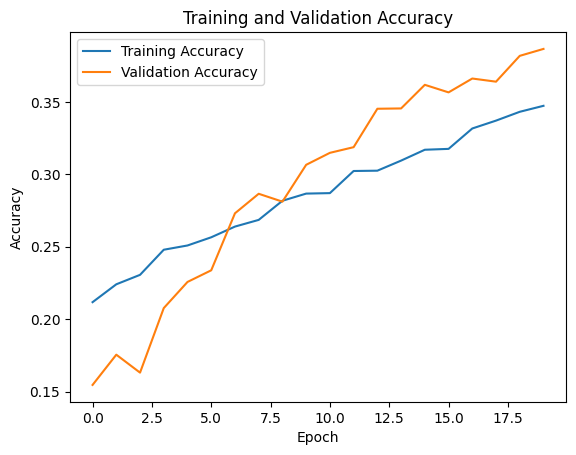

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


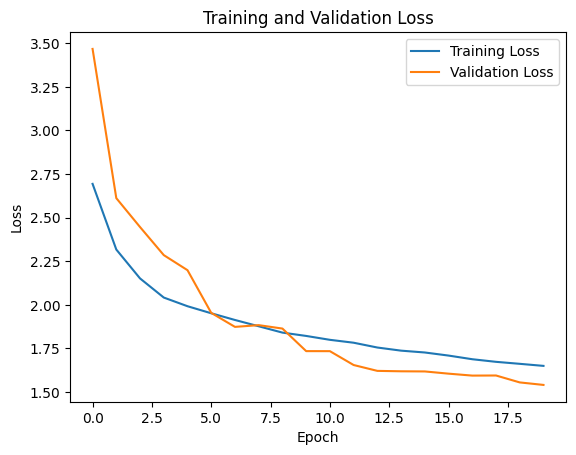

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

80/80 [==============================] - 1s 11ms/step - loss: 1.5341 - accuracy: 0.3855
Test Loss: 1.5340713262557983
Test Accuracy: 0.3854573965072632


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


80/80 [==============================] - 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

       happy       0.31      0.54      0.40       390
     disgust       0.36      0.10      0.16       375
       angry       0.36      0.27      0.30       369
         sad       0.28      0.13      0.18       328
        fear       0.63      0.80      0.70       289
    surprise       0.46      0.47      0.47       415
     neutral       0.31      0.43      0.36       392

    accuracy                           0.39      2558
   macro avg       0.39      0.39      0.37      2558
weighted avg       0.38      0.39      0.36      2558



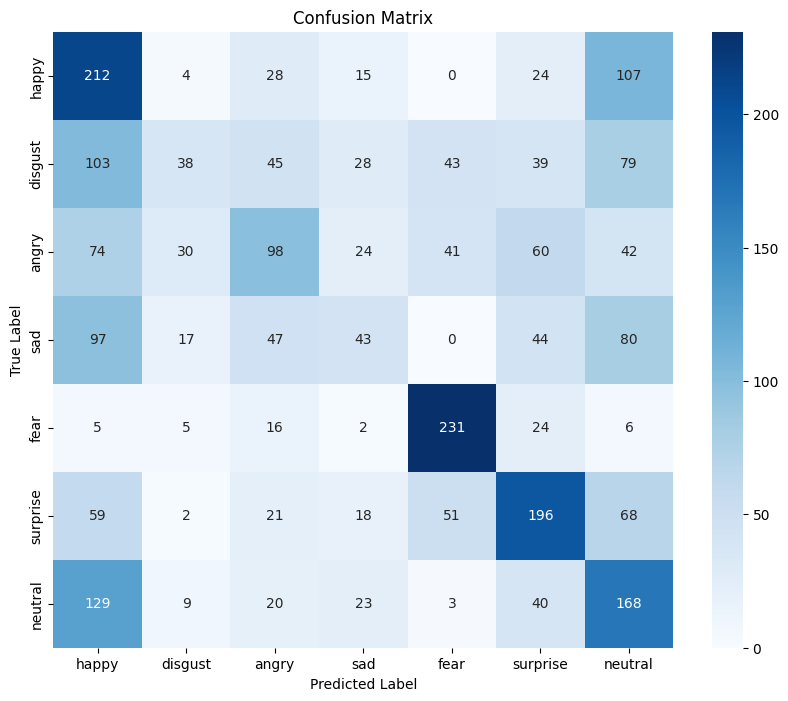

In [21]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


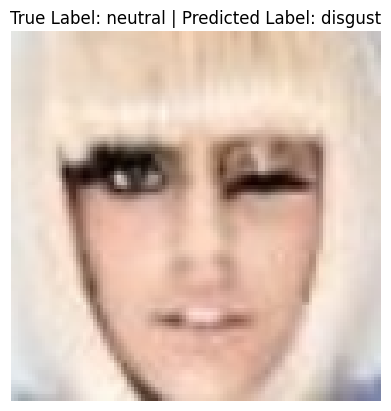

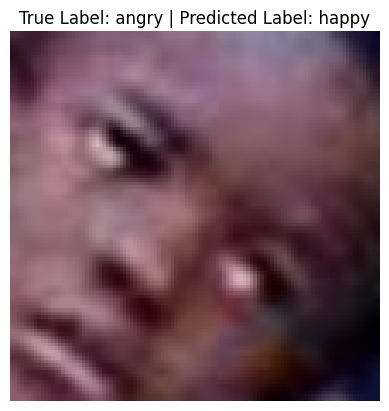

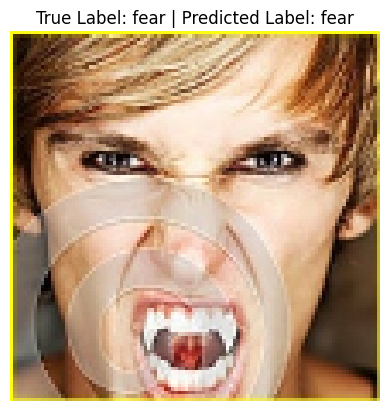

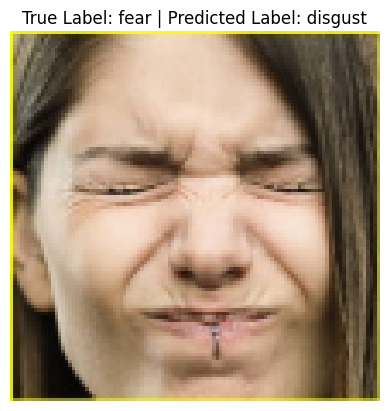

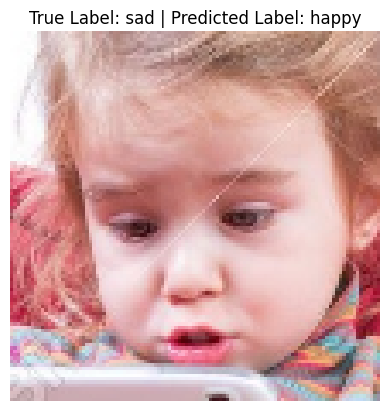

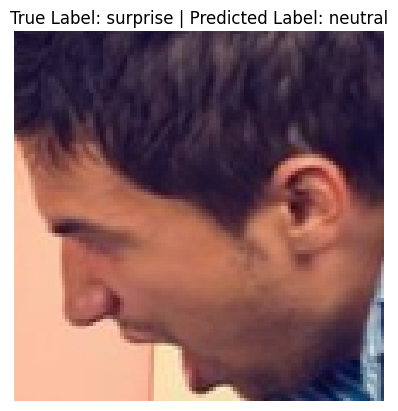

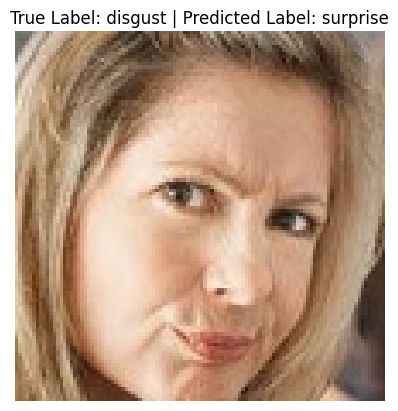

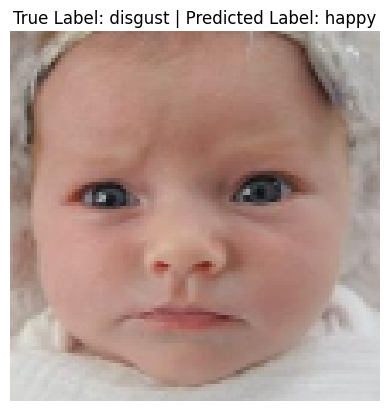

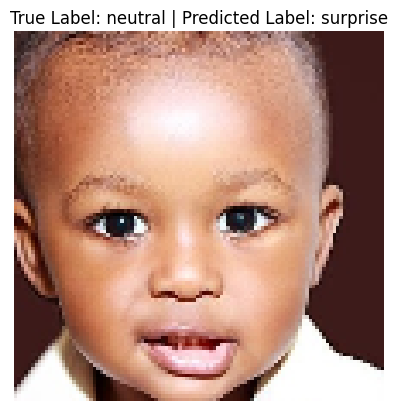

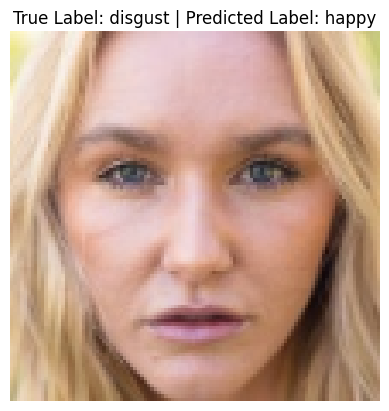

In [22]:
# Test some images
def test_image(index):
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title("True Label: {} | Predicted Label: {}".format(class_names[y_true[index]], class_names[y_pred_classes[index]]))
    plt.show()

# Test random images
for _ in range(10):
    random_index = np.random.randint(0, len(X_test))
    test_image(random_index)